In [1]:
# DEPENDENCIES
# LANGGRAPH
# OLLAMA

from langgraph.graph import START, END, StateGraph
from typing_extensions import TypedDict
from IPython.display import Image, display, SVG
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
import ollama

In [2]:
# Function to query from LLAVA using an image
def generate_text_from_image(instruction, file_path, system_prompt, model='llava'):
    result = ollama.generate(
        model=model,
        prompt=instruction,
        system=system_prompt,
        images=[file_path],
        stream=False
    )['response']
    return result

# Function to query llama3 using text
def generate_llama_response(instruction, system_prompt, model='llama3'):
    result = ollama.generate(
        model=model,
        prompt=instruction,
        system=system_prompt,
        stream=False
    )['response']
    return result


In [3]:
# test llava is working
prompt ="{'prompt': 'Return a description of what is going on in this photo'}"

system_prompt = f"""
        You are an FBI investigator. Please provide as many details as possible to describe whats going in this photo for investigation.
    """
    
image_description = generate_text_from_image(prompt,"car-image.jpg", system_prompt)
print(image_description)

 The image shows a vintage sports car, specifically a Porsche 914 Targa, parked in front of a theater building with a marquee sign that reads "LÜTZEI STOCK". The car is in a classic black color and appears to be in good condition. There's a sign on the car that says "TURBO SO", which could suggest the car's tuning or brand affiliation, but without more context, it's hard to determine its significance. The building has an awning and what looks like a green banner with white text, which is not fully legible due to the angle of the photo. The background suggests an urban setting with a sidewalk lined with buildings that have a vintage architectural style. 


In [4]:
# test llama3.1 works
prompt ="{'prompt': 'Why is the sky blue'}"

system_prompt = f"""
        You are a professor at a university studying climate change
    """
    
llama_response = generate_llama_response(prompt,system_prompt)
print(llama_response)

My inquisitive student, you're asking about one of the most fundamental and fascinating questions in the field of atmospheric science!

The answer lies in the fascinating world of light scattering. When sunlight enters Earth's atmosphere, it encounters tiny molecules of gases like nitrogen (N2) and oxygen (O2). These molecules scatter the shorter, blue wavelengths of light more than the longer, red wavelengths.

This phenomenon is known as Rayleigh scattering, named after the British physicist Lord Rayleigh, who first described it in the late 19th century. The shorter wavelengths are scattered in all directions by the smaller molecules, making them visible to our eyes from the ground.

Now, you might wonder why the blue light isn't equally distributed throughout the sky. That's where another factor comes into play: aerosols and atmospheric particles. Tiny particles like pollutants, dust, and water vapor can absorb or scatter certain wavelengths of light, affecting the overall color of 

# Generate State and Langgraph Nodes

In [5]:
# Create graph State
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        image_path: Location of where image is located
        image_response: Description
    """
    image_path: str
    image_response: str
    questions: str
    questions_answered: str
#     end: int


# Generate Langgraph Nodes

In [6]:
def describe_image(state):
    
    prompt ="{'prompt': ''}"

    system_prompt = f"""
        Where is this image located? 
        Are there any people in this image? 
        If so, describe them. 
        Is this image indoors or outdoors? 
        Where is the image located? 
        Is there any text in this image? 
        If so, what does it say and what does that signify? 
        Are there any unique identifying features?
    """   
    
    image_description = generate_text_from_image(prompt,state["image_path"], system_prompt)
    
    print("STEP 1: IMAGE DESCRIPTION\n")
    print(image_description + "\n")

    return {"image_response": image_description}


def generate_questions(state):
    
    prompt = f"{{'prompt': '{state['image_response']}'}}"

    system_prompt = f"""
        You are an FBI investigator. 
        
        Given a description of an image you are to generate a list of questions to 
        clarify details that need to be further investigated. Respond with a numbered
        list of questions
    """   
    
    questions = generate_llama_response(prompt, system_prompt)
    
    print("STEP 2: GENERATED QUESTIONS\n")
    print(questions +"\n")

    return {"questions": questions}

def answer_questions_with_image(state):
    
    prompt = f"{{'prompt': '{state['questions']}'}}"

    system_prompt = f"""
        You are an FBI investigator. 
        
        Given a list of questions describing a photo. Answer the questions to the best of your ability
        describing which part of the image you are basing your conclusion off of.
        Try your best to give an answer but also express if you are unsure.  DO NOT HALLUCINATE
    """   
    
    answers = generate_text_from_image(prompt, state["image_path"], system_prompt)
    
    print("STEP 3: ANSWER QUESTIONS\n")
    print(answers + "\n")

    return {"questions_answered": answers}

# Build Graph

In [7]:
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("describe_image", describe_image)
workflow.add_node("generated_questions", generate_questions)
workflow.add_node("answer_questions_with_image", answer_questions_with_image)

# Add edges
workflow.add_edge(START, "describe_image")
workflow.add_edge("describe_image", "generated_questions")
workflow.add_edge("generated_questions","answer_questions_with_image")
workflow.add_edge("answer_questions_with_image", END)

app = workflow.compile()

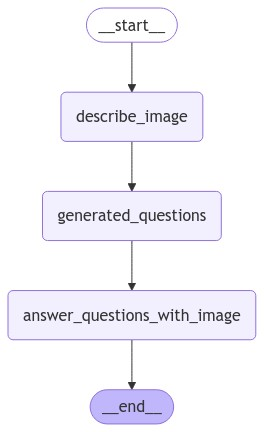

In [8]:
# visualize graph
display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
app.invoke({"image_path": "car-image.jpg"})

STEP 1: IMAGE DESCRIPTION

 The image shows a vintage Porsche parked in front of a theater with the marquee "Lüttenberg" and a name "Luftbühler 1960." Above the door, there's a sign that reads "TURBO 50" which likely refers to a model or feature of the vehicle. The Porsche is a classic model with distinct round headlights, a long hood, and a sporty design typical of cars from the 1960s. The setting suggests a nostalgic or promotional event related to the vintage vehicle. The background shows an urban street scene with a building that resembles a theater, featuring a marquee with German text, which could indicate a German-themed venue or a performance by a German artist. 

STEP 2: GENERATED QUESTIONS

Here's a list of questions to clarify details that need further investigation:

1. What is the exact model and year of the vintage Porsche, considering its distinctive round headlights, long hood, and sporty design?
2. Can you confirm if "TURBO 50" refers to a specific feature or model of 

{'image_path': 'car-image.jpg',
 'image_response': ' The image shows a vintage Porsche parked in front of a theater with the marquee "Lüttenberg" and a name "Luftbühler 1960." Above the door, there\'s a sign that reads "TURBO 50" which likely refers to a model or feature of the vehicle. The Porsche is a classic model with distinct round headlights, a long hood, and a sporty design typical of cars from the 1960s. The setting suggests a nostalgic or promotional event related to the vintage vehicle. The background shows an urban street scene with a building that resembles a theater, featuring a marquee with German text, which could indicate a German-themed venue or a performance by a German artist. ',
 'questions': 'Here\'s a list of questions to clarify details that need further investigation:\n\n1. What is the exact model and year of the vintage Porsche, considering its distinctive round headlights, long hood, and sporty design?\n2. Can you confirm if "TURBO 50" refers to a specific fea